# MNIST Standard Biological Images: CNN2D with Bagging

In [62]:
import time
from datetime import datetime
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [63]:
# Get date/time for local timezone
def get_localdate_str():
    tm_str = str(datetime.now())
    return tm_str

def get_time_with_minutes(date_str):
    tm_str = re.sub('^....-..-.. ', "", date_str)
    tm_str = re.sub(':..\.......$', "", tm_str)
    tm_str = re.sub(":", "-", tm_str)
    return tm_str

def get_date_with_seconds(date_str):
    tm_str = re.sub('\.......$', "", date_str)
    tm_str = re.sub(" ", "_", date_str)
    return tm_str

In [64]:
def display_eval_graphs(ttl, epochs, trn_acc, val_acc, trn_loss, val_loss, xlab, ylab_acc, ylab_loss):
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))    
    fig.suptitle(ttl)
    
    ax1.plot(epochs, trn_acc, label='training accuracy')
    ax1.plot(epochs, val_acc, label='validation accuracy')
    #plt.plot  ( epochs, accuracy, label = 'training accuracy' )
    #plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
    ax1.set_title(ylab_acc)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab_acc)
    ax1.legend(loc = 'best')

    ax2.plot(epochs, trn_loss, label='training loss')
    ax2.plot(epochs, val_loss, label='validation loss')
    ax2.set_title(ylab_loss)
    ax2.set_xlabel(xlab)
    ax2.set_ylabel(ylab_loss)
    fig.subplots_adjust(wspace=0.5)
    ax2.legend(loc = 'best')

    plt.show()

In [65]:
def create_base_model(image_dim, num_classes, learning_rate):
    model = Sequential([
        layers.InputLayer(image_dim),
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dense(num_classes, activation='softmax')
    ])
    # Compile the model
    adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
def train_bagging_ensemble(fn, n_members, x_train, y_train, x_test, y_test, n_classes, epoch_num, lr, img_dim):
    ensemble = []
    n_samples = x_train.shape[0]
    elapsed_train_total = 0

    for i in range(n_members):
        #print(f"Training model {i+1}/{n_members}...")

        # Create a bootstrap sample (with replacement)
        bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
        x_bootstrap = x_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        # Create the base model
        model = create_base_model(img_dim, n_classes, lr)

        ttl = fn + ": Epochs " + str(epoch_num) + ", LR " + str(lr)

        # Train the base model
        start_train = time.time()
        #model.fit(x_bootstrap, y_bootstrap, epochs=epoch_num, batch_size=64, verbose=0)
        # Train the model
        history = model.fit(
                x=x_bootstrap,
                y=y_bootstrap,
                epochs=epoch_num,
                batch_size=64,
                validation_split=0.1,
                validation_data=(x_test, y_test),
                verbose=0)
        elapsed_train = time.time() - start_train
        elapsed_train_total += elapsed_train
        print(f"  Model {i+1} of {n_members} training time: {round(elapsed_train, 2)} seconds")
        
        ensemble.append(model)

        accuracy = history.history['accuracy']
        loss = history.history['loss']
        v_accuracy = history.history['val_accuracy']
        v_loss = history.history['val_loss']

        if i+1 == n_members:
            epoch_cnt   = range(len(accuracy)) # Get number of epochs
            display_eval_graphs(ttl, epoch_cnt, accuracy, v_accuracy, loss, v_loss, "Epochs", "Accuracy", "Loss")

    #print(f"Ensemble training time: {round(elapsed_train_total, 2)} seconds")
        
    return ensemble, elapsed_train_total

In [67]:
def ensemble_predict(ensemble, x_test):
    # Get predictions from each model
    ensemble_predictions = [model.predict(x_test, verbose=0) for model in ensemble]
    
    # Average the predicted probabilities
    avg_predictions = np.mean(ensemble_predictions, axis=0)
    
    # Return the class with the highest average probability
    return np.argmax(avg_predictions, axis=1)

In [68]:
def load_and_process(fn):
    npz_f = np.load(fn, allow_pickle=True)
    print(f"\n{fn}")
    
    train_f = npz_f['train_images']
    test_f = npz_f['test_images']
    val_f = npz_f['val_images']
    features = np.concatenate((train_f, test_f, val_f), axis = 0)
    print(f"features.shape: {features.shape}")

    train_l = npz_f['train_labels']
    test_l = npz_f['test_labels']
    val_l = npz_f['val_labels']
    labels = np.concatenate((train_l, test_l, val_l), axis = 0)
    print(f"labels.shape: {labels.shape}")

    # Apply random shufflynig to combined dataset.
    np.random.seed(0)
    indices = np.arange(features.shape[0])
    shuffled_indices = np.random.permutation(indices)
    X = features[shuffled_indices]
    y = labels[shuffled_indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}")
    
    return npz_f, X_train, X_test, y_train, y_test

In [69]:
def process_one_file(fn):
    
    csv_data = [[]]
    
    # Load and preprocess the data
    npz_file, x_train, x_test, y_train, y_test = load_and_process(fn)

    # Find number of unique classes within data set
    class_cnt, value_cnts = np.unique(y_train, return_counts=True)
    print(f"class_cnt: {class_cnt}")
    print(f"value_cnts: {value_cnts}")
    n_classes = len(class_cnt)
    print(f"n_classes: {n_classes}")

    # Get shape for a single image
    img_shape = x_train.shape
    #print(f"img_shape: {img_shape}")
    img_dim = []
    for ix in range(1, len(img_shape)):
        img_dim.append(img_shape[ix])
    print("img_dim:", img_dim)

    # Display the first image and label in the training data
    print("\nLabel: ", y_train[0])
    if len(img_dim) < 3 or img_dim[2] == 3:
        #img_arr = original_imgs[feature_keys[0]]
        img = x_train[0]
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Convert class vectors to one-hot encoded format
    y_train = to_categorical(y_train, n_classes)
    y_test = to_categorical(y_test, n_classes)

    n_members = 5
    #n_members = 2

    #lrn_rates = [0.1]
    lrn_rates = [0.1, 0.01, 0.001]
    #epoch_range = [10]
    epoch_range = [10, 25, 50, 100, 150]
    
    for l_rate in lrn_rates:
        
        for num_epochs in epoch_range:

            print(f"\n{fn}, epochs: {num_epochs}, lr: {l_rate}")

            # Train 5 models for the ensemble
            ensemble_models, trn_elapsed = train_bagging_ensemble(fn, n_members, x_train, y_train, x_test, y_test, \
                                                     n_classes, num_epochs, l_rate, img_dim)
            # Make predictions on the test set
            y_pred_ensemble = ensemble_predict(ensemble_models, x_test)
            y_test_labels = np.argmax(y_test, axis=1)

            # Evaluate the ensemble
            accuracy = accuracy_score(y_test_labels, y_pred_ensemble)
            loss = -1.0

            print(f"Ensemble Training time: {round(trn_elapsed, 2)} seconds")
            print(f"Ensemble Accuracy: {accuracy * 100:.3f}%, Loss: {round(loss, 5)}, Epochs: {num_epochs}, LR {l_rate}")
            csv_row = np.array([fn, l_rate, num_epochs, round(accuracy * 100, 2), \
                                round(loss, 5), round(trn_elapsed, 2)])
            csv_data.append(csv_row)

    npz_file.close()
            
    return csv_data


bloodmnist.npz
features.shape: (17092, 28, 28, 3)
labels.shape: (17092, 1)
X_train.shape: (13673, 28, 28, 3)
y_train.shape: (13673, 1)
X_test.shape: (3419, 28, 28, 3)
y_test.shape: (3419, 1)
class_cnt: [0 1 2 3 4 5 6 7]
value_cnts: [ 955 2493 1239 2304  974 1142 2670 1896]
n_classes: 8
img_dim: [28, 28, 3]

Label:  [6]


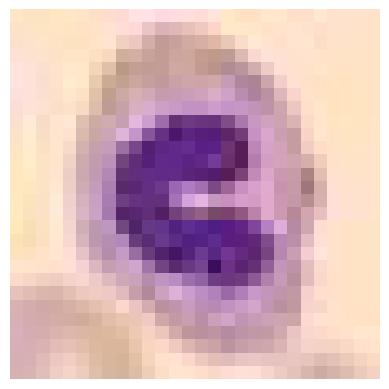


bloodmnist.npz, epochs: 10, lr: 0.1
  Model 1 of 5 training time: 10.49 seconds
  Model 2 of 5 training time: 10.17 seconds
  Model 3 of 5 training time: 10.96 seconds
  Model 4 of 5 training time: 10.7 seconds
  Model 5 of 5 training time: 10.49 seconds


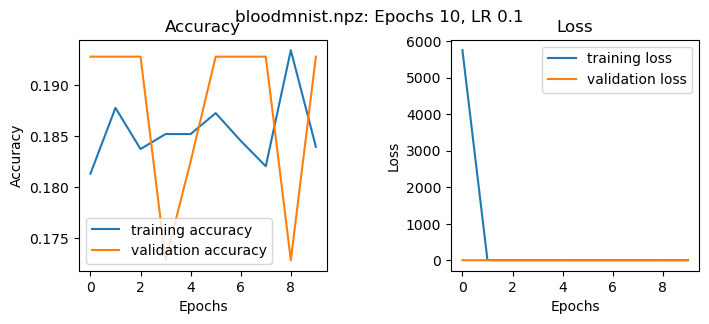

Ensemble training time: 52.82 seconds
Ensemble Accuracy: 18.25%
Ensemble Training time: 52.82 seconds
Ensemble Accuracy: 18.251, Loss: -1.0, Epochs: 10, LR 0.1

bloodmnist.npz, epochs: 25, lr: 0.1
  Model 1 of 5 training time: 24.88 seconds
  Model 2 of 5 training time: 24.86 seconds
  Model 3 of 5 training time: 24.81 seconds
  Model 4 of 5 training time: 24.66 seconds
  Model 5 of 5 training time: 25.2 seconds


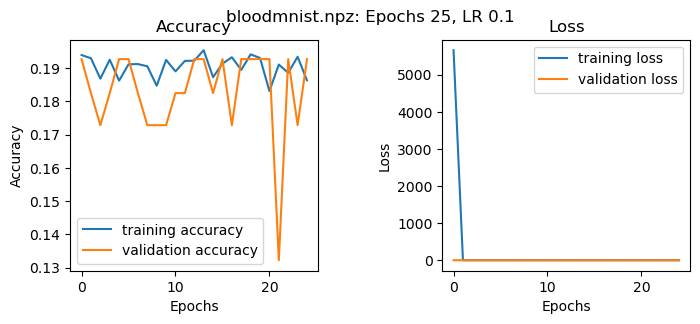

Ensemble training time: 124.4 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 124.4 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 25, LR 0.1

bloodmnist.npz, epochs: 50, lr: 0.1
  Model 1 of 5 training time: 49.15 seconds
  Model 2 of 5 training time: 48.79 seconds
  Model 3 of 5 training time: 49.31 seconds
  Model 4 of 5 training time: 49.11 seconds
  Model 5 of 5 training time: 50.32 seconds


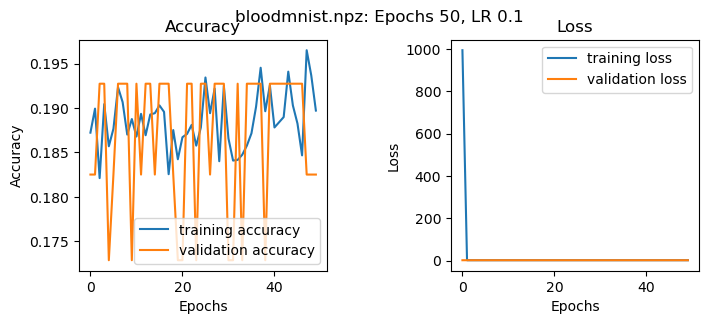

Ensemble training time: 246.68 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 246.68 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 50, LR 0.1

bloodmnist.npz, epochs: 100, lr: 0.1
  Model 1 of 5 training time: 97.58 seconds
  Model 2 of 5 training time: 97.83 seconds
  Model 3 of 5 training time: 99.08 seconds
  Model 4 of 5 training time: 99.21 seconds
  Model 5 of 5 training time: 98.1 seconds


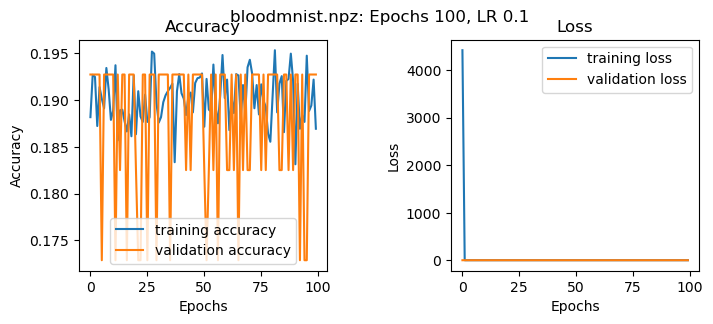

Ensemble training time: 491.81 seconds
Ensemble Accuracy: 18.25%
Ensemble Training time: 491.81 seconds
Ensemble Accuracy: 18.251, Loss: -1.0, Epochs: 100, LR 0.1

bloodmnist.npz, epochs: 150, lr: 0.1
  Model 1 of 5 training time: 146.59 seconds
  Model 2 of 5 training time: 144.73 seconds
  Model 3 of 5 training time: 149.29 seconds
  Model 4 of 5 training time: 149.4 seconds
  Model 5 of 5 training time: 146.49 seconds


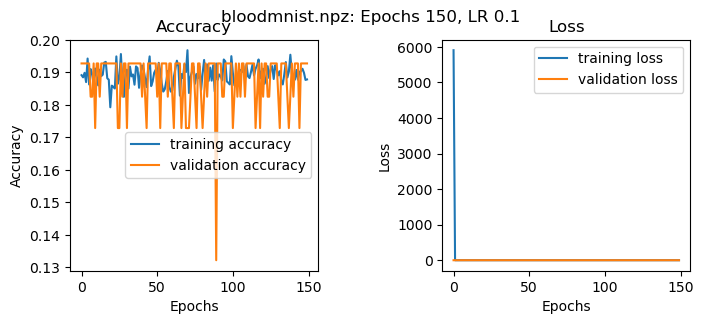

Ensemble training time: 736.5 seconds
Ensemble Accuracy: 18.25%
Ensemble Training time: 736.5 seconds
Ensemble Accuracy: 18.251, Loss: -1.0, Epochs: 150, LR 0.1

bloodmnist.npz, epochs: 10, lr: 0.01
  Model 1 of 5 training time: 10.21 seconds
  Model 2 of 5 training time: 10.24 seconds
  Model 3 of 5 training time: 11.49 seconds
  Model 4 of 5 training time: 10.85 seconds
  Model 5 of 5 training time: 10.76 seconds


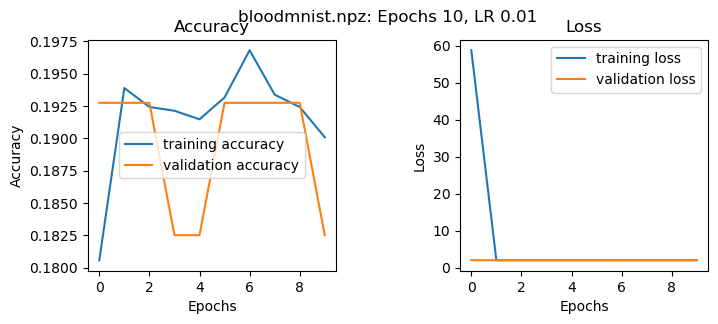

Ensemble training time: 53.56 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 53.56 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 10, LR 0.01

bloodmnist.npz, epochs: 25, lr: 0.01
  Model 1 of 5 training time: 25.68 seconds
  Model 2 of 5 training time: 25.15 seconds
  Model 3 of 5 training time: 25.16 seconds
  Model 4 of 5 training time: 24.85 seconds
  Model 5 of 5 training time: 24.61 seconds


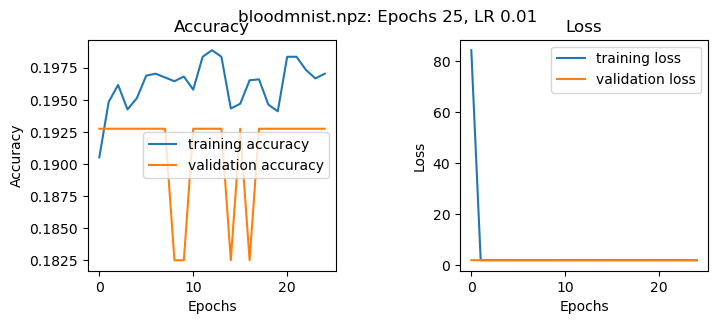

Ensemble training time: 125.43 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 125.43 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 25, LR 0.01

bloodmnist.npz, epochs: 50, lr: 0.01
  Model 1 of 5 training time: 48.64 seconds
  Model 2 of 5 training time: 49.08 seconds
  Model 3 of 5 training time: 48.94 seconds
  Model 4 of 5 training time: 48.86 seconds
  Model 5 of 5 training time: 48.56 seconds


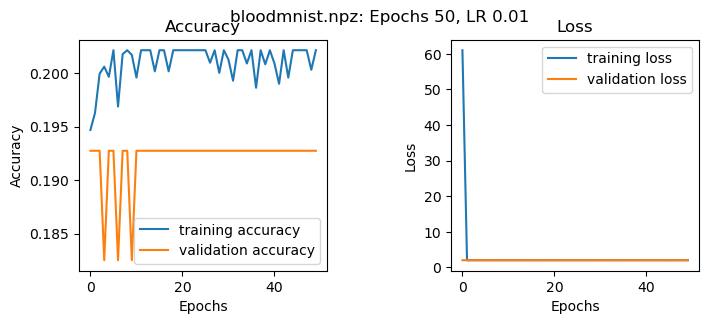

Ensemble training time: 244.09 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 244.09 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 50, LR 0.01

bloodmnist.npz, epochs: 100, lr: 0.01
  Model 1 of 5 training time: 96.34 seconds
  Model 2 of 5 training time: 96.8 seconds
  Model 3 of 5 training time: 97.44 seconds
  Model 4 of 5 training time: 97.79 seconds
  Model 5 of 5 training time: 106.03 seconds


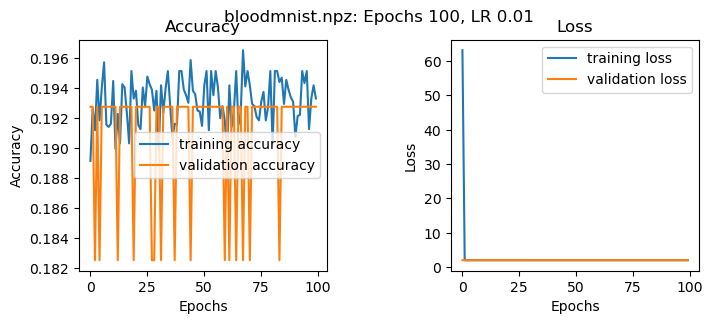

Ensemble training time: 494.4 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 494.4 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 100, LR 0.01

bloodmnist.npz, epochs: 150, lr: 0.01
  Model 1 of 5 training time: 155.37 seconds
  Model 2 of 5 training time: 154.0 seconds
  Model 3 of 5 training time: 151.4 seconds
  Model 4 of 5 training time: 149.13 seconds
  Model 5 of 5 training time: 148.01 seconds


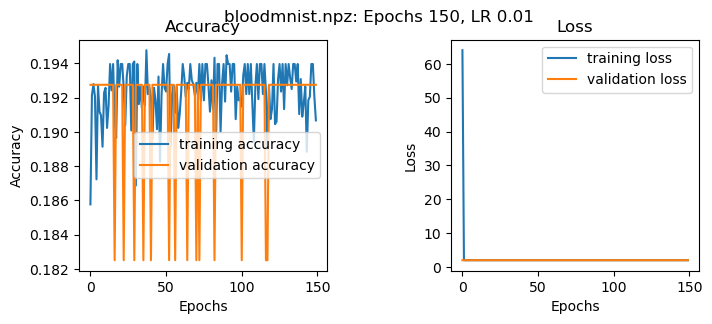

Ensemble training time: 757.92 seconds
Ensemble Accuracy: 19.27%
Ensemble Training time: 757.92 seconds
Ensemble Accuracy: 19.275, Loss: -1.0, Epochs: 150, LR 0.01

bloodmnist.npz, epochs: 10, lr: 0.001
  Model 1 of 5 training time: 10.43 seconds
  Model 2 of 5 training time: 10.27 seconds
  Model 3 of 5 training time: 10.44 seconds
  Model 4 of 5 training time: 10.36 seconds
  Model 5 of 5 training time: 10.29 seconds


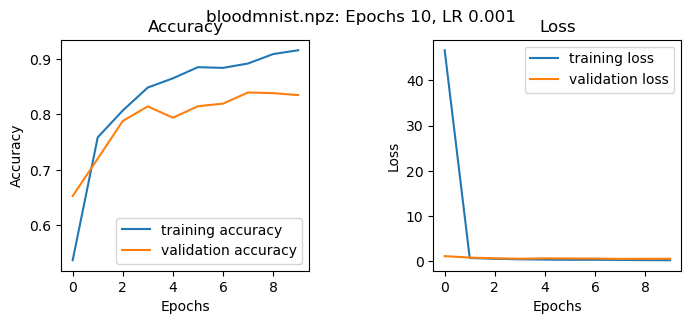

Ensemble training time: 51.79 seconds
Ensemble Accuracy: 89.27%
Ensemble Training time: 51.79 seconds
Ensemble Accuracy: 89.266, Loss: -1.0, Epochs: 10, LR 0.001

bloodmnist.npz, epochs: 25, lr: 0.001
  Model 1 of 5 training time: 25.19 seconds
  Model 2 of 5 training time: 24.68 seconds
  Model 3 of 5 training time: 24.87 seconds
  Model 4 of 5 training time: 24.79 seconds
  Model 5 of 5 training time: 24.83 seconds


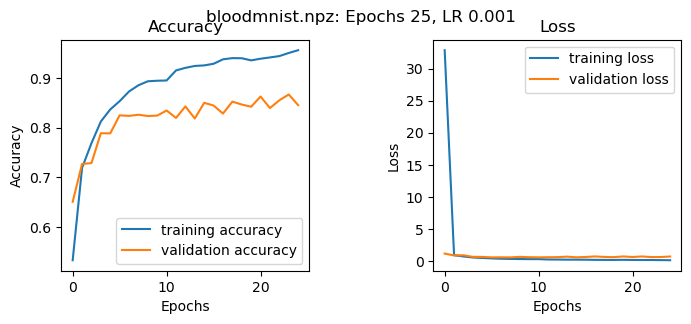

Ensemble training time: 124.36 seconds
Ensemble Accuracy: 91.84%
Ensemble Training time: 124.36 seconds
Ensemble Accuracy: 91.84, Loss: -1.0, Epochs: 25, LR 0.001

bloodmnist.npz, epochs: 50, lr: 0.001
  Model 1 of 5 training time: 48.8 seconds
  Model 2 of 5 training time: 48.65 seconds
  Model 3 of 5 training time: 55.42 seconds
  Model 4 of 5 training time: 53.76 seconds
  Model 5 of 5 training time: 53.2 seconds


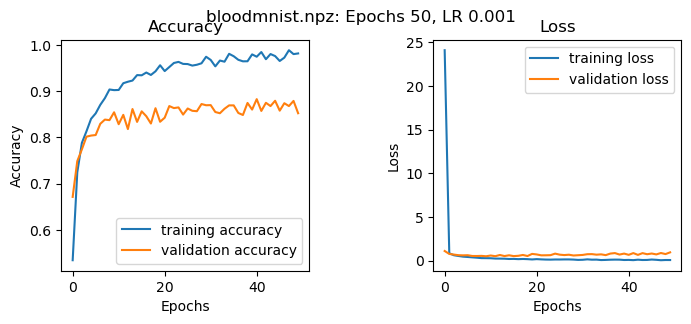

Ensemble training time: 259.82 seconds
Ensemble Accuracy: 91.93%
Ensemble Training time: 259.82 seconds
Ensemble Accuracy: 91.927, Loss: -1.0, Epochs: 50, LR 0.001

bloodmnist.npz, epochs: 100, lr: 0.001
  Model 1 of 5 training time: 103.06 seconds
  Model 2 of 5 training time: 100.92 seconds
  Model 3 of 5 training time: 101.09 seconds
  Model 4 of 5 training time: 101.17 seconds
  Model 5 of 5 training time: 100.68 seconds


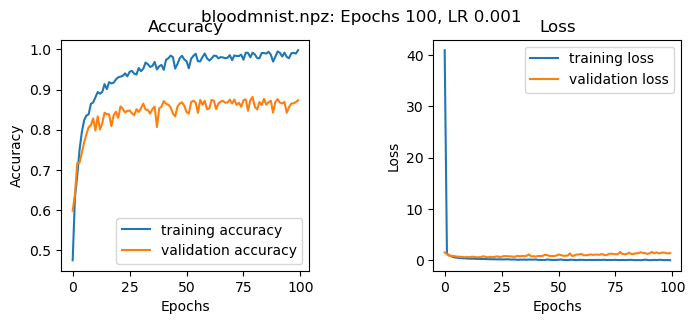

Ensemble training time: 506.92 seconds
Ensemble Accuracy: 93.10%
Ensemble Training time: 506.92 seconds
Ensemble Accuracy: 93.097, Loss: -1.0, Epochs: 100, LR 0.001

bloodmnist.npz, epochs: 150, lr: 0.001
  Model 1 of 5 training time: 147.25 seconds
  Model 2 of 5 training time: 146.9 seconds
  Model 3 of 5 training time: 145.13 seconds
  Model 4 of 5 training time: 147.12 seconds
  Model 5 of 5 training time: 146.0 seconds


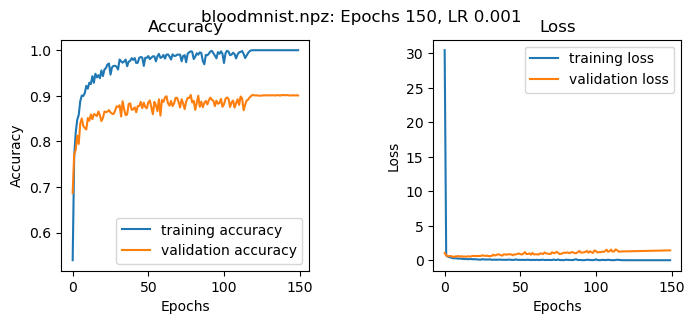

Ensemble training time: 732.4 seconds
Ensemble Accuracy: 93.51%
Ensemble Training time: 732.4 seconds
Ensemble Accuracy: 93.507, Loss: -1.0, Epochs: 150, LR 0.001

dermamnist.npz
features.shape: (10015, 28, 28, 3)
labels.shape: (10015, 1)
X_train.shape: (8012, 28, 28, 3)
y_train.shape: (8012, 1)
X_test.shape: (2003, 28, 28, 3)
y_test.shape: (2003, 1)
class_cnt: [0 1 2 3 4 5 6]
value_cnts: [ 260  429  885   92  866 5365  115]
n_classes: 7
img_dim: [28, 28, 3]

Label:  [2]


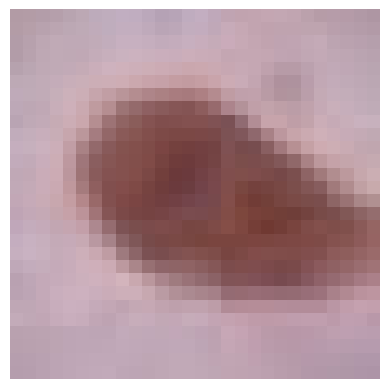


dermamnist.npz, epochs: 10, lr: 0.1
  Model 1 of 5 training time: 6.56 seconds
  Model 2 of 5 training time: 6.51 seconds
  Model 3 of 5 training time: 6.52 seconds
  Model 4 of 5 training time: 6.59 seconds
  Model 5 of 5 training time: 6.54 seconds


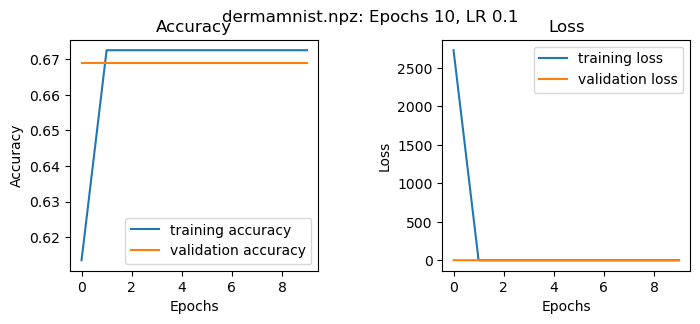

Ensemble training time: 32.71 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 32.71 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 10, LR 0.1

dermamnist.npz, epochs: 25, lr: 0.1
  Model 1 of 5 training time: 15.39 seconds
  Model 2 of 5 training time: 15.43 seconds
  Model 3 of 5 training time: 15.34 seconds
  Model 4 of 5 training time: 15.42 seconds
  Model 5 of 5 training time: 18.16 seconds


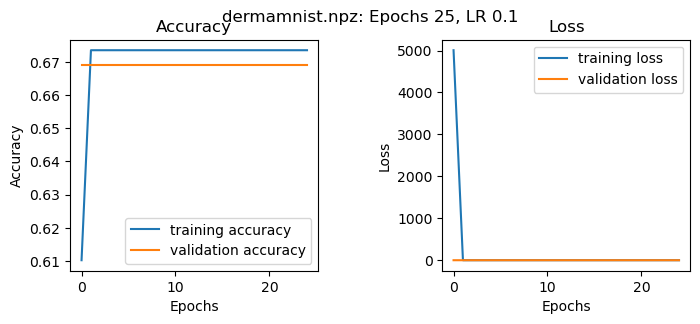

Ensemble training time: 79.75 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 79.75 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 25, LR 0.1

dermamnist.npz, epochs: 50, lr: 0.1
  Model 1 of 5 training time: 33.14 seconds
  Model 2 of 5 training time: 32.54 seconds
  Model 3 of 5 training time: 32.03 seconds
  Model 4 of 5 training time: 31.68 seconds
  Model 5 of 5 training time: 31.35 seconds


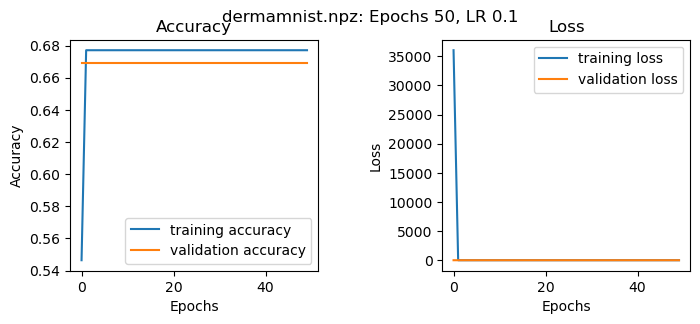

Ensemble training time: 160.74 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 160.74 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 50, LR 0.1

dermamnist.npz, epochs: 100, lr: 0.1
  Model 1 of 5 training time: 61.05 seconds
  Model 2 of 5 training time: 61.42 seconds
  Model 3 of 5 training time: 60.52 seconds
  Model 4 of 5 training time: 59.6 seconds
  Model 5 of 5 training time: 59.73 seconds


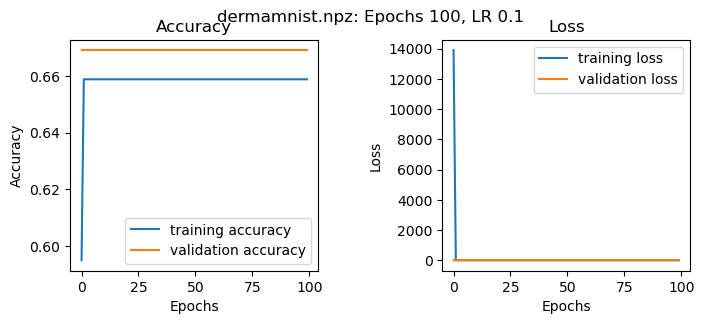

Ensemble training time: 302.33 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 302.33 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 100, LR 0.1

dermamnist.npz, epochs: 150, lr: 0.1
  Model 1 of 5 training time: 89.11 seconds
  Model 2 of 5 training time: 88.95 seconds
  Model 3 of 5 training time: 212.58 seconds
  Model 4 of 5 training time: 92.48 seconds
  Model 5 of 5 training time: 91.42 seconds


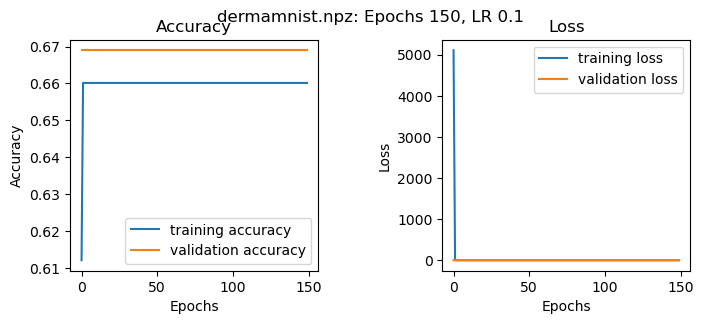

Ensemble training time: 574.54 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 574.54 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 150, LR 0.1

dermamnist.npz, epochs: 10, lr: 0.01
  Model 1 of 5 training time: 6.62 seconds
  Model 2 of 5 training time: 6.6 seconds
  Model 3 of 5 training time: 6.82 seconds
  Model 4 of 5 training time: 6.6 seconds
  Model 5 of 5 training time: 6.69 seconds


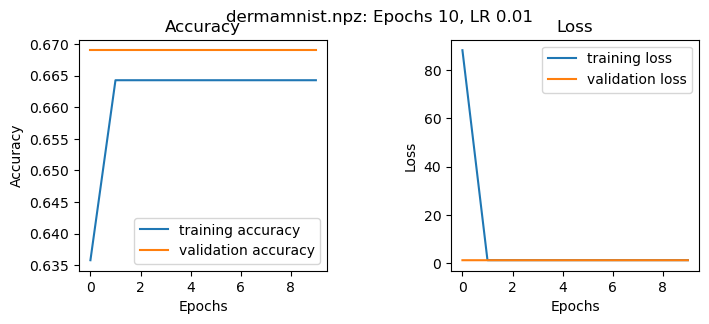

Ensemble training time: 33.33 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 33.33 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 10, LR 0.01

dermamnist.npz, epochs: 25, lr: 0.01
  Model 1 of 5 training time: 15.61 seconds
  Model 2 of 5 training time: 15.57 seconds
  Model 3 of 5 training time: 15.51 seconds
  Model 4 of 5 training time: 15.76 seconds
  Model 5 of 5 training time: 15.34 seconds


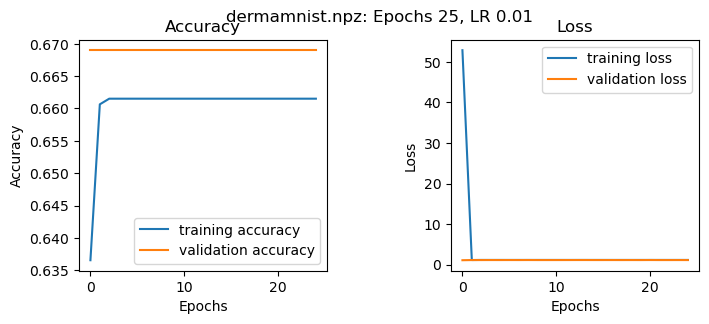

Ensemble training time: 77.78 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 77.78 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 25, LR 0.01

dermamnist.npz, epochs: 50, lr: 0.01
  Model 1 of 5 training time: 35.25 seconds
  Model 2 of 5 training time: 34.64 seconds
  Model 3 of 5 training time: 33.73 seconds
  Model 4 of 5 training time: 32.86 seconds
  Model 5 of 5 training time: 32.48 seconds


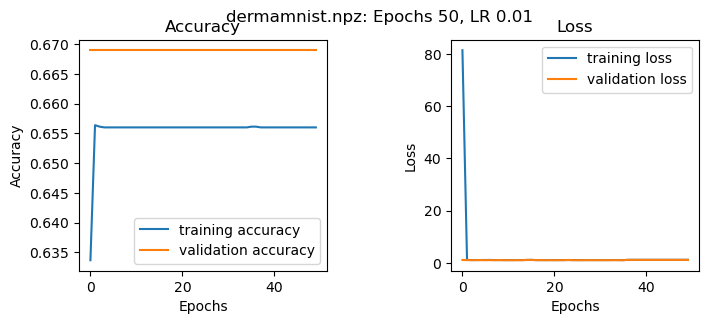

Ensemble training time: 168.97 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 168.97 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 50, LR 0.01

dermamnist.npz, epochs: 100, lr: 0.01
  Model 1 of 5 training time: 64.1 seconds
  Model 2 of 5 training time: 62.43 seconds
  Model 3 of 5 training time: 61.42 seconds
  Model 4 of 5 training time: 61.41 seconds
  Model 5 of 5 training time: 61.85 seconds


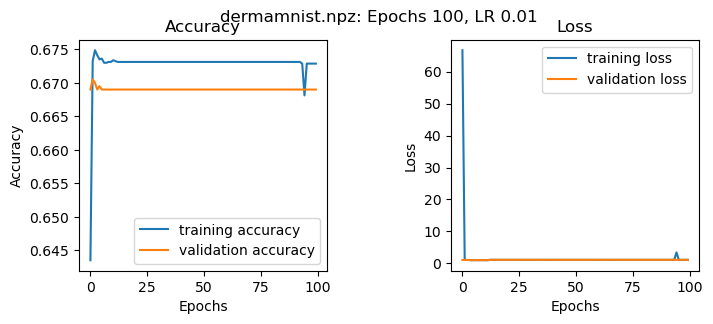

Ensemble training time: 311.21 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 311.21 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 100, LR 0.01

dermamnist.npz, epochs: 150, lr: 0.01
  Model 1 of 5 training time: 91.62 seconds
  Model 2 of 5 training time: 91.34 seconds
  Model 3 of 5 training time: 90.93 seconds
  Model 4 of 5 training time: 90.93 seconds
  Model 5 of 5 training time: 90.33 seconds


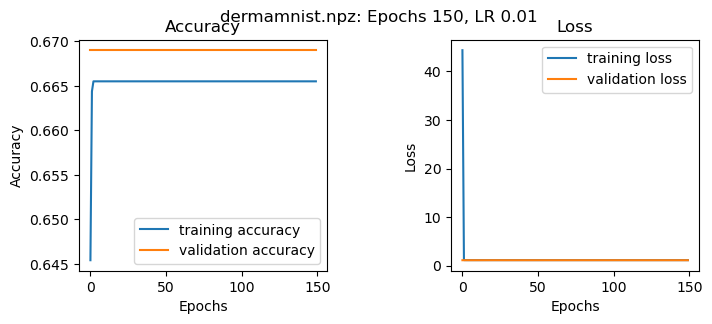

Ensemble training time: 455.15 seconds
Ensemble Accuracy: 66.90%
Ensemble Training time: 455.15 seconds
Ensemble Accuracy: 66.9, Loss: -1.0, Epochs: 150, LR 0.01

dermamnist.npz, epochs: 10, lr: 0.001
  Model 1 of 5 training time: 6.69 seconds
  Model 2 of 5 training time: 6.6 seconds
  Model 3 of 5 training time: 6.72 seconds
  Model 4 of 5 training time: 6.61 seconds
  Model 5 of 5 training time: 6.5 seconds


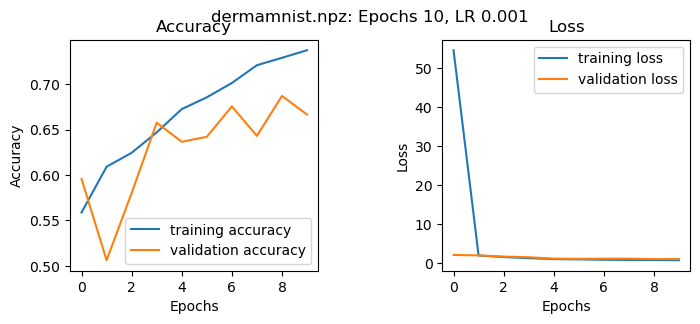

Ensemble training time: 33.11 seconds
Ensemble Accuracy: 71.14%
Ensemble Training time: 33.11 seconds
Ensemble Accuracy: 71.143, Loss: -1.0, Epochs: 10, LR 0.001

dermamnist.npz, epochs: 25, lr: 0.001
  Model 1 of 5 training time: 15.52 seconds
  Model 2 of 5 training time: 15.53 seconds
  Model 3 of 5 training time: 15.45 seconds
  Model 4 of 5 training time: 15.46 seconds
  Model 5 of 5 training time: 15.71 seconds


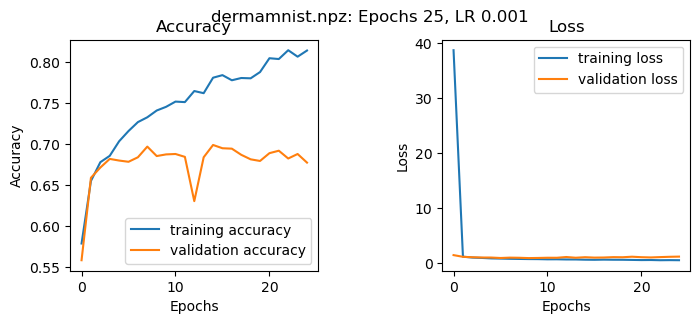

Ensemble training time: 77.68 seconds
Ensemble Accuracy: 71.54%
Ensemble Training time: 77.68 seconds
Ensemble Accuracy: 71.543, Loss: -1.0, Epochs: 25, LR 0.001

dermamnist.npz, epochs: 50, lr: 0.001
  Model 1 of 5 training time: 30.27 seconds
  Model 2 of 5 training time: 30.25 seconds
  Model 3 of 5 training time: 30.38 seconds
  Model 4 of 5 training time: 30.12 seconds
  Model 5 of 5 training time: 37.88 seconds


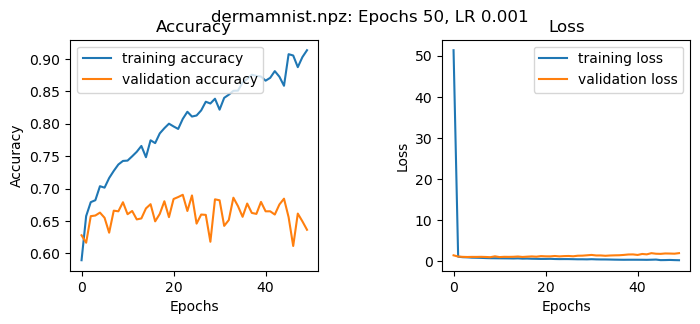

Ensemble training time: 158.9 seconds
Ensemble Accuracy: 73.79%
Ensemble Training time: 158.9 seconds
Ensemble Accuracy: 73.789, Loss: -1.0, Epochs: 50, LR 0.001

dermamnist.npz, epochs: 100, lr: 0.001
  Model 1 of 5 training time: 70.68 seconds
  Model 2 of 5 training time: 68.31 seconds
  Model 3 of 5 training time: 65.74 seconds
  Model 4 of 5 training time: 65.07 seconds
  Model 5 of 5 training time: 64.6 seconds


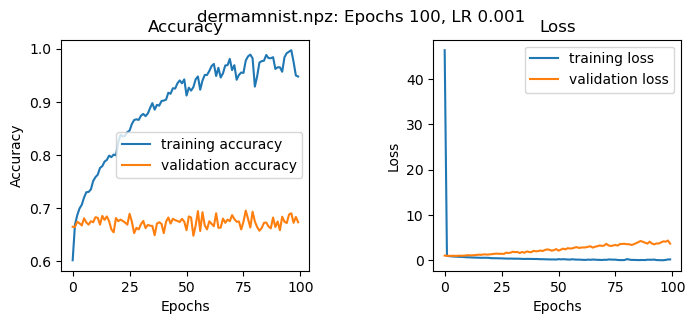

Ensemble training time: 334.4 seconds
Ensemble Accuracy: 72.69%
Ensemble Training time: 334.4 seconds
Ensemble Accuracy: 72.691, Loss: -1.0, Epochs: 100, LR 0.001

dermamnist.npz, epochs: 150, lr: 0.001
  Model 1 of 5 training time: 94.1 seconds
  Model 2 of 5 training time: 92.83 seconds
  Model 3 of 5 training time: 91.13 seconds
  Model 4 of 5 training time: 90.84 seconds
  Model 5 of 5 training time: 91.97 seconds


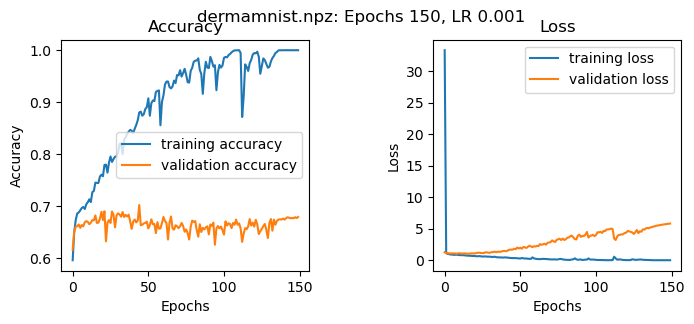

Ensemble training time: 460.86 seconds
Ensemble Accuracy: 73.14%
Ensemble Training time: 460.86 seconds
Ensemble Accuracy: 73.14, Loss: -1.0, Epochs: 150, LR 0.001

retinamnist_128.npz
features.shape: (1600, 128, 128, 3)
labels.shape: (1600, 1)
X_train.shape: (1280, 128, 128, 3)
y_train.shape: (1280, 1)
X_test.shape: (320, 128, 128, 3)
y_test.shape: (320, 1)
class_cnt: [0 1 2 3 4]
value_cnts: [581 143 260 225  71]
n_classes: 5
img_dim: [128, 128, 3]

Label:  [2]


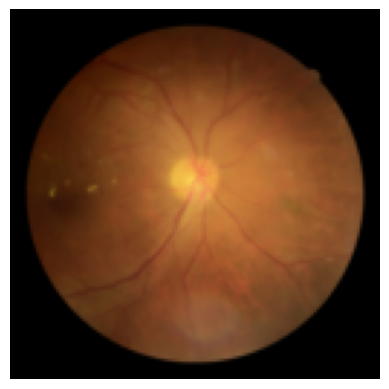


retinamnist_128.npz, epochs: 10, lr: 0.1
  Model 1 of 5 training time: 18.23 seconds
  Model 2 of 5 training time: 18.27 seconds
  Model 3 of 5 training time: 18.4 seconds
  Model 4 of 5 training time: 18.24 seconds
  Model 5 of 5 training time: 19.28 seconds


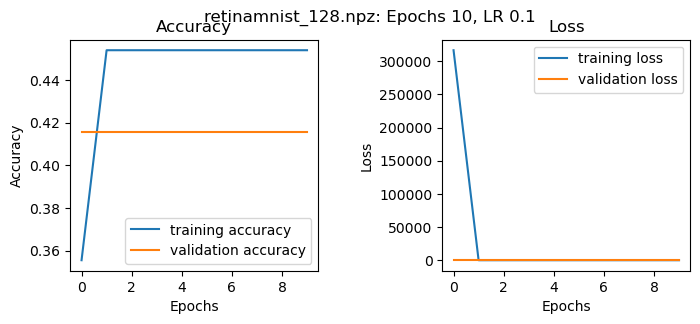

Ensemble training time: 92.41 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 92.41 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 10, LR 0.1

retinamnist_128.npz, epochs: 25, lr: 0.1
  Model 1 of 5 training time: 44.33 seconds
  Model 2 of 5 training time: 44.21 seconds
  Model 3 of 5 training time: 44.4 seconds
  Model 4 of 5 training time: 44.69 seconds
  Model 5 of 5 training time: 44.37 seconds


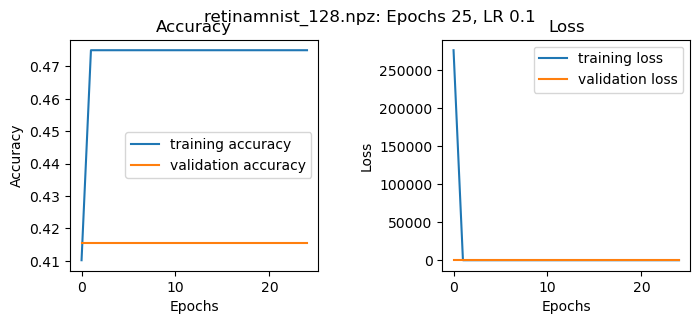

Ensemble training time: 222.0 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 222.0 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 25, LR 0.1

retinamnist_128.npz, epochs: 50, lr: 0.1
  Model 1 of 5 training time: 88.1 seconds
  Model 2 of 5 training time: 88.02 seconds
  Model 3 of 5 training time: 88.14 seconds
  Model 4 of 5 training time: 88.1 seconds
  Model 5 of 5 training time: 87.81 seconds


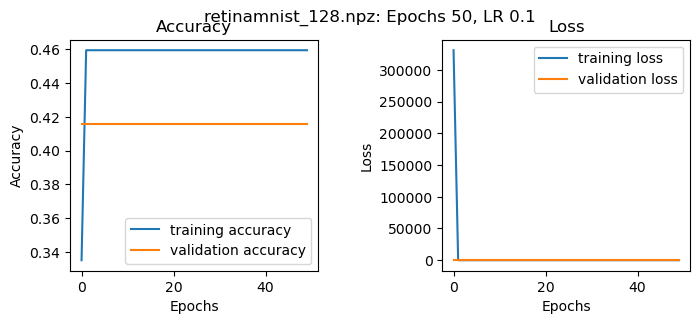

Ensemble training time: 440.17 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 440.17 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 50, LR 0.1

retinamnist_128.npz, epochs: 100, lr: 0.1
  Model 1 of 5 training time: 175.32 seconds
  Model 2 of 5 training time: 175.25 seconds
  Model 3 of 5 training time: 174.89 seconds
  Model 4 of 5 training time: 175.97 seconds
  Model 5 of 5 training time: 175.44 seconds


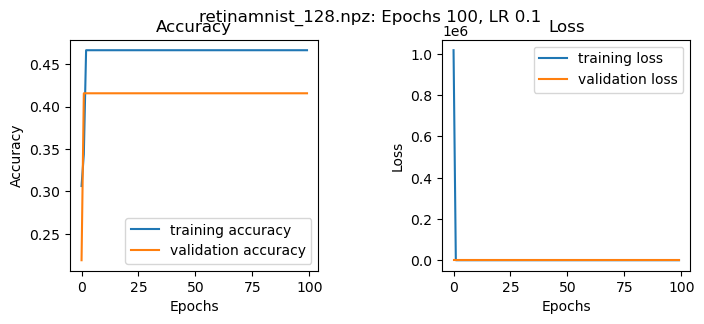

Ensemble training time: 876.86 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 876.86 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 100, LR 0.1

retinamnist_128.npz, epochs: 150, lr: 0.1
  Model 1 of 5 training time: 262.62 seconds
  Model 2 of 5 training time: 263.17 seconds
  Model 3 of 5 training time: 263.99 seconds
  Model 4 of 5 training time: 262.5 seconds
  Model 5 of 5 training time: 263.9 seconds


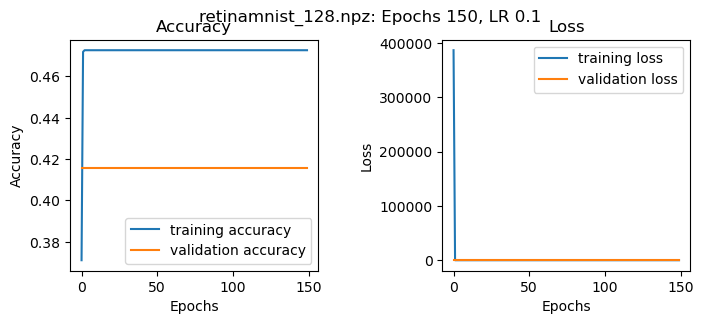

Ensemble training time: 1316.19 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 1316.19 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 150, LR 0.1

retinamnist_128.npz, epochs: 10, lr: 0.01
  Model 1 of 5 training time: 18.84 seconds
  Model 2 of 5 training time: 18.63 seconds
  Model 3 of 5 training time: 18.65 seconds
  Model 4 of 5 training time: 18.61 seconds
  Model 5 of 5 training time: 18.73 seconds


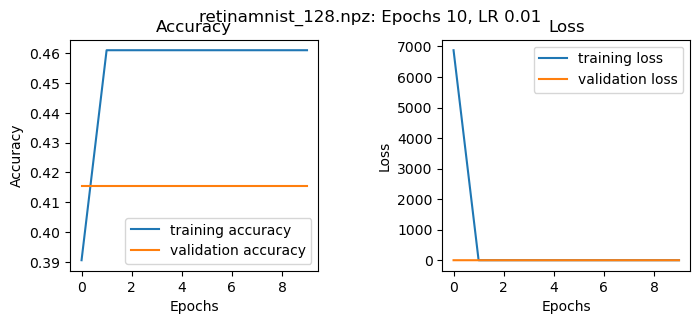

Ensemble training time: 93.46 seconds
Ensemble Accuracy: 42.81%
Ensemble Training time: 93.46 seconds
Ensemble Accuracy: 42.812, Loss: -1.0, Epochs: 10, LR 0.01

retinamnist_128.npz, epochs: 25, lr: 0.01
  Model 1 of 5 training time: 45.65 seconds
  Model 2 of 5 training time: 45.42 seconds
  Model 3 of 5 training time: 45.45 seconds
  Model 4 of 5 training time: 45.34 seconds
  Model 5 of 5 training time: 44.94 seconds


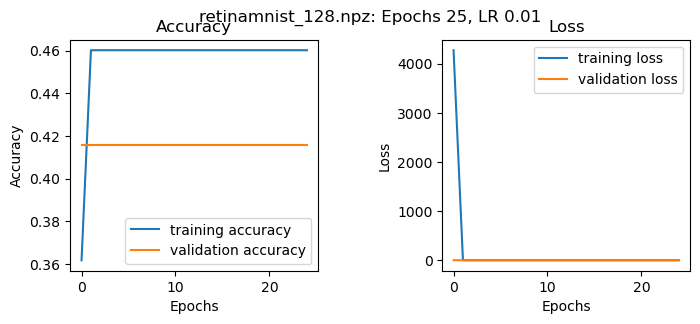

Ensemble training time: 226.81 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 226.81 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 25, LR 0.01

retinamnist_128.npz, epochs: 50, lr: 0.01
  Model 1 of 5 training time: 88.89 seconds
  Model 2 of 5 training time: 89.15 seconds
  Model 3 of 5 training time: 88.83 seconds
  Model 4 of 5 training time: 88.37 seconds
  Model 5 of 5 training time: 89.23 seconds


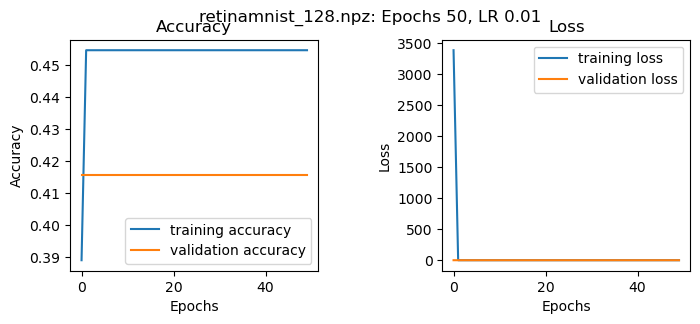

Ensemble training time: 444.46 seconds
Ensemble Accuracy: 41.56%
Ensemble Training time: 444.46 seconds
Ensemble Accuracy: 41.562, Loss: -1.0, Epochs: 50, LR 0.01

retinamnist_128.npz, epochs: 100, lr: 0.01
  Model 1 of 5 training time: 176.81 seconds
  Model 2 of 5 training time: 177.19 seconds
  Model 3 of 5 training time: 175.77 seconds
  Model 4 of 5 training time: 175.59 seconds
  Model 5 of 5 training time: 176.07 seconds


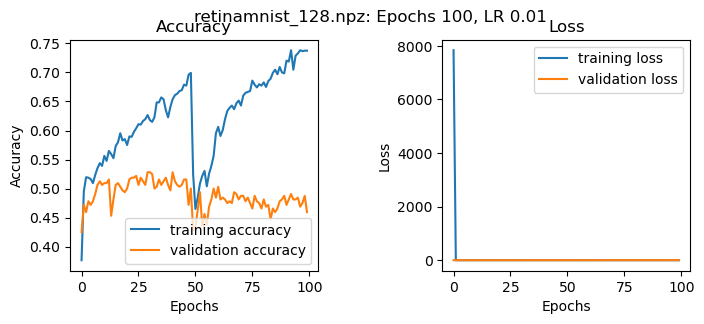

Ensemble training time: 881.43 seconds
Ensemble Accuracy: 50.31%
Ensemble Training time: 881.43 seconds
Ensemble Accuracy: 50.313, Loss: -1.0, Epochs: 100, LR 0.01

retinamnist_128.npz, epochs: 150, lr: 0.01
  Model 1 of 5 training time: 263.43 seconds
  Model 2 of 5 training time: 263.55 seconds
  Model 3 of 5 training time: 262.51 seconds
  Model 4 of 5 training time: 263.89 seconds
  Model 5 of 5 training time: 263.63 seconds


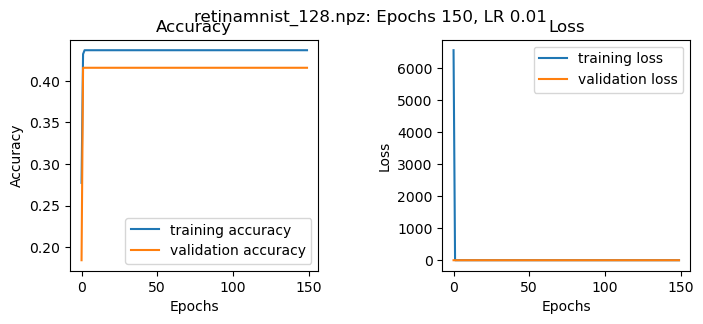

Ensemble training time: 1317.0 seconds
Ensemble Accuracy: 41.88%
Ensemble Training time: 1317.0 seconds
Ensemble Accuracy: 41.875, Loss: -1.0, Epochs: 150, LR 0.01

retinamnist_128.npz, epochs: 10, lr: 0.001
  Model 1 of 5 training time: 18.1 seconds
  Model 2 of 5 training time: 18.16 seconds
  Model 3 of 5 training time: 18.18 seconds
  Model 4 of 5 training time: 18.16 seconds
  Model 5 of 5 training time: 18.3 seconds


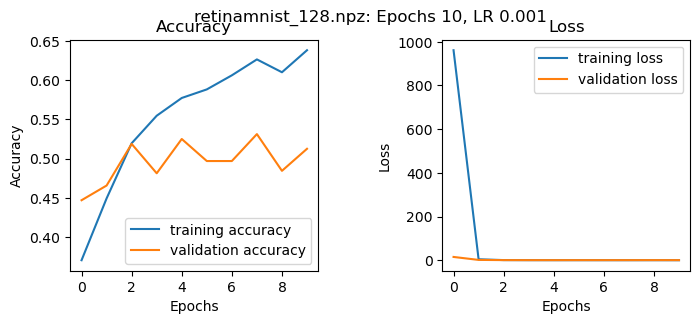

Ensemble training time: 90.9 seconds
Ensemble Accuracy: 53.12%
Ensemble Training time: 90.9 seconds
Ensemble Accuracy: 53.125, Loss: -1.0, Epochs: 10, LR 0.001

retinamnist_128.npz, epochs: 25, lr: 0.001
  Model 1 of 5 training time: 44.89 seconds
  Model 2 of 5 training time: 44.54 seconds
  Model 3 of 5 training time: 44.36 seconds
  Model 4 of 5 training time: 44.53 seconds
  Model 5 of 5 training time: 44.45 seconds


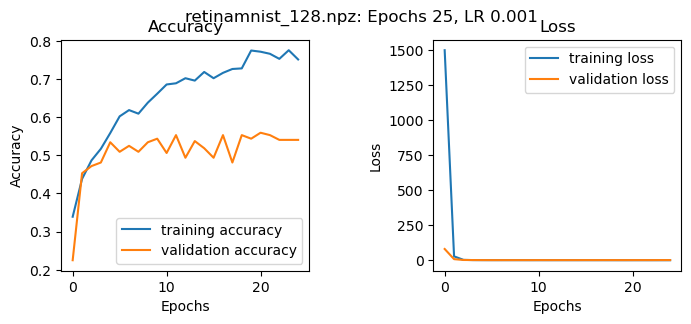

Ensemble training time: 222.78 seconds
Ensemble Accuracy: 55.31%
Ensemble Training time: 222.78 seconds
Ensemble Accuracy: 55.312, Loss: -1.0, Epochs: 25, LR 0.001

retinamnist_128.npz, epochs: 50, lr: 0.001
  Model 1 of 5 training time: 88.72 seconds
  Model 2 of 5 training time: 88.52 seconds
  Model 3 of 5 training time: 88.15 seconds
  Model 4 of 5 training time: 88.03 seconds
  Model 5 of 5 training time: 88.42 seconds


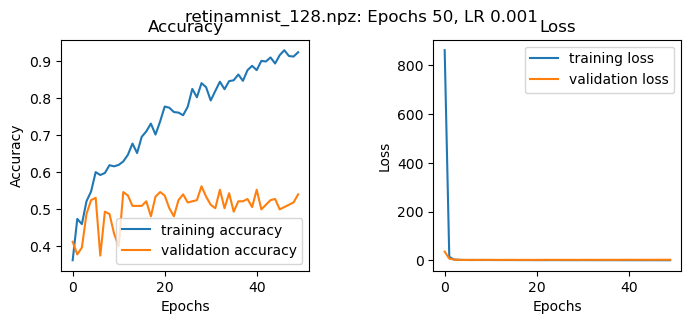

Ensemble training time: 441.85 seconds
Ensemble Accuracy: 53.75%
Ensemble Training time: 441.85 seconds
Ensemble Accuracy: 53.75, Loss: -1.0, Epochs: 50, LR 0.001

retinamnist_128.npz, epochs: 100, lr: 0.001
  Model 1 of 5 training time: 175.88 seconds
  Model 2 of 5 training time: 183.57 seconds
  Model 3 of 5 training time: 182.05 seconds
  Model 4 of 5 training time: 181.34 seconds
  Model 5 of 5 training time: 181.01 seconds


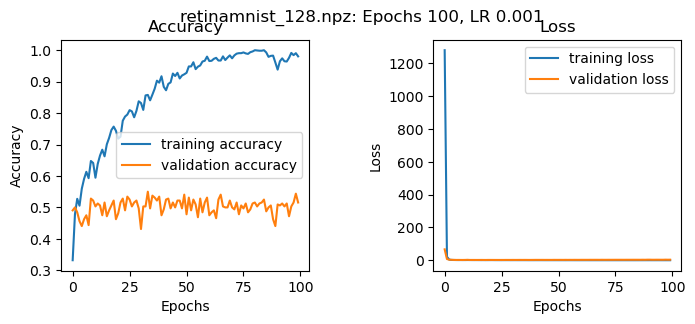

Ensemble training time: 903.84 seconds
Ensemble Accuracy: 54.06%
Ensemble Training time: 903.84 seconds
Ensemble Accuracy: 54.062, Loss: -1.0, Epochs: 100, LR 0.001

retinamnist_128.npz, epochs: 150, lr: 0.001
  Model 1 of 5 training time: 270.41 seconds
  Model 2 of 5 training time: 270.06 seconds
  Model 3 of 5 training time: 269.3 seconds
  Model 4 of 5 training time: 268.59 seconds
  Model 5 of 5 training time: 267.4 seconds


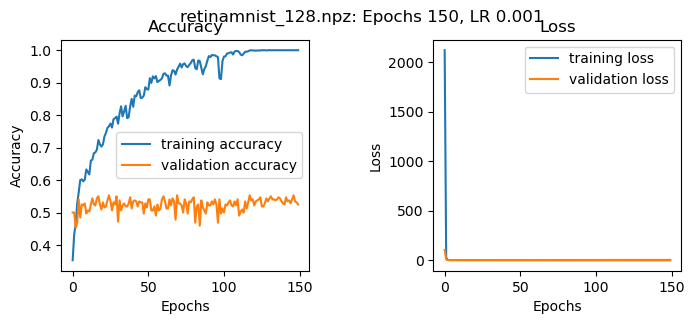

Ensemble training time: 1345.75 seconds
Ensemble Accuracy: 55.31%
Ensemble Training time: 1345.75 seconds
Ensemble Accuracy: 55.312, Loss: -1.0, Epochs: 150, LR 0.001

DONE: Total Run Time: 287 minutes : 0.0 seconds


In [70]:
#files = ['dermamnist.npz']
files = ['bloodmnist.npz', 'dermamnist.npz', 'retinamnist_128.npz']

first_write = True

dtmin = get_time_with_minutes(get_localdate_str())
outfile = "CCN2DBagging-" + dtmin +".csv"

start_run = time.time()

for fn in files:
    csv_info = process_one_file(fn)
    
    # Append the CSV data to a new or existing CSV file
    df = pd.DataFrame(csv_info, columns=['fn','lr','epochs','accuracy','loss','train time'])
    if (first_write):
        # write to file (create or overwrite)
        df = pd.DataFrame(csv_info, columns=['fn','lr','epochs','accuracy','loss','train time'])
        df.to_csv(outfile, index=False)
        first_write = False
    else:
        # append to file
        df.to_csv(outfile, mode='a', index=False, header=False)

end_run = time.time() - start_run

if end_run > 180.0:
    end_run_min = end_run / 60.0
    end_run = end_run - end_run_min * 60.0
    print(f"\nDONE: Total Run Time: {int(end_run_min)} minutes : {round(end_run, 2)} seconds")
else:
    print(f"\nDONE: Total Run Time: {round(end_run, 2)} seconds")